In [1]:
import pandas as pd
import numpy as np
import copy
import datetime
import time

### RTTM to Dataframe

In [2]:
# Step 1: Load the .rttm into a dataframe
def DfFromRttm(rttm):
    """ Given an RTTM file, parses it into a Pandas DataFrame.
    """
    df = pd.read_csv(rttm,
                     sep=' ',
                     names=['task','inputFile','one','start','duration',
                     'NA_1','NA_2','class','NA_3', 'NA_4'])    
    
    # Drop the columns we don't care about from a base RTTM
    vizframe = copy.deepcopy(df) \
        .drop(
        columns=[
            'task',
            'inputFile',
            'one',
            'NA_1',
            'NA_2',
            'NA_3',
            'NA_4'])
    
    return vizframe

## Dealing with DIHARD RTTMs
The DIHARD-generated dataframes come with sequential labels for each segment derived from `A`...`Z` and then appending an extra character. (Sort of like Excel column names.)

We need to convert them to `SPEECH` before we can use them in the rest of our pipeline.

In [16]:
def SpeechifyDihardDF(input_df,
                       new_label = 'SPEECH',
                       verbose   = False):
    """ Given a DIHARD-generated dataframe
        with labels of type A-Z, AA-AZ, BA-BZ, etc.
        replace the class labels with a label of your
        choosing.
    """
    input_df['class'] = new_label
    
    if verbose:
        input_df.head(5)
    return input_df

## Audiozation Data

In [4]:
def RttmToUtteranceIndexedSpeakerActivity(df, outfile=None):
    """ Given an RTTM input file, generate a dataframe structured
        to support a visualization of type 'Speaker Activity' and optionally
        export to a csv located at {outfile}

        df = Pandas DataFrame containing a standard .rttm file
        outfile = destination for exported CSV (path, filename, extension)
    """

    # Check whether an outfile has been defined
    if outfile is not None:
        export = True
    else: 
        export = False

    # Drop the columns we don't care about from a base RTTM
    vizframe = copy.deepcopy(df) 

    # Rename columns for our viz's purposes
    vizframe = vizframe.rename(columns={
        'start': 'START',
        'duration': 'DUR',
        'class': 'LABEL'
    })

    # Remap the model classes for this viz's purposes
    vizframe['LABEL'] = vizframe['LABEL'].map({
        'KCHI': 'CHILD',
        'CHI': 'CHILD',
        'FEM': 'ADULT',
        'MAL': 'ADULT'
    })

    # Filter the dataframe to just the 'clean' (non-'SPEECH') classes
    vizframe = vizframe[vizframe['LABEL'].isin(['CHILD', 'ADULT'])]
    vizframe['LABEL_NUM'] = vizframe['LABEL'] \
        .apply(lambda x: 1 if x == 'CHILD'
               else (-1 if x == 'ADULT' else NaN))
    vizframe['DUR_TRANS'] = vizframe['LABEL_NUM'] * vizframe['DUR']
    vizframe['COUNT'] = 1

    if export:
        vizframe.to_csv(outfile)

    return vizframe

## Time-Indexed Dataframe

In [5]:
## Identify the latest timestamp we need.
def GetLatestTimestampNeeded(input_df, verbose=True):
    """ Given an RTTM-derived dataframe,
        extract the last timestamp we'll need
        as a scalar. It will be the maximum value of
        the `start` + `duration` columns.
    """
    input_df['end_time'] = input_df['start'] + input_df['duration']
    end_row = input_df['end_time'].idxmax()
    latest_timestamp = input_df.at[end_row,'start'] + input_df.at[end_row,'duration']
    if verbose:
        print(f'''
        >> This DF has data that runs until {latest_timestamp}.
        >> That value was found at row {end_row} and is the sum of
           {input_df.at[end_row, 'start']} and {input_df.at[end_row, 'duration']}
        ''')
    return latest_timestamp

In [6]:
## Create millisecond index.
def MakeMillisecondIntegerIndexedDf(
        start,
        duration,
        colname='value',
        colvalue='',
        decimals=4,
        verbose=False):
    """ Create an integer-indexed dataframe covering a 
            {duration} from
            {start} having a single column with the name
            {colname} that contains a default value of
            {colvalue} for that named column.
        By default it runs quietly rather than {verbose}.
    """

    if verbose:
        print(f' >>> From [{start}] for [{duration}] seconds' \
              f' until [{start+duration}] the col [{colname}]' \
              f' will contain the value [{colvalue}]')
    
    # Create a range between the start and stop
    rng = pd.RangeIndex(start = int(round(start, decimals)*1000),
                        stop  = int(round(start+duration, decimals)*1000),
                        step  = 1)
    
    # Turn that series into a DataFrame and rename the index for clarity
    df = pd.Series(colvalue, index=rng).to_frame(name=colname)
    df.index.name=f'millisecond_ints'
    if verbose:
        print(df.head(3), df.tail(3))
    return df

In [7]:
## Subset by label.
def SubsetDfByLabel(df, column_list, key_col, value):
    """ Given a dataframe {df}, return the subset
        of the dataframe defined by {column_list}
        containing {value} in the {key_col} column
    """
    return df[df[key_col] == value][[x for x in column_list]]

In [19]:
def BuildOneHotEncodedDf(
    input_df,
    label_list=[],
    verbose=True
    ):
    """ Given an RTTM-generated DataFrame, generate a DF containing
        all of the labels of interest in one-hot encoded format
        against an integer-indexed DF representing milliseconds from
        the beginning of the recording
    """
    
    max_seconds_needed = GetLatestTimestampNeeded(input_df)
    if verbose:
        print(f'max_seconds_needed is equal to {max_seconds_needed}')

    outer_df = MakeMillisecondIntegerIndexedDf(
                start      = 0,
                duration   = max_seconds_needed,
                colname    = 'base_col',
                colvalue   = np.nan,
                decimals   = 4,
                verbose    = True)

    if verbose:
        print(f'The outer_df frame will contain {outer_df.shape[0]} records.')
    
    # Loop through labels, subsetting the original DF so
    # we can merge it back into the main outer DF
    for label in label_list:
        print(f'>>> Processing label: {label}\n')

        if label not in input_df['class'].unique():
            print(f'Label {label} not found in this dataset')
            label_base_df = pd.DataFrame(columns=[label])
            continue
        
        # Gotta avoid errors from accidentally manipulating original DFs
        temp_df = copy.deepcopy(input_df)

        # Replace the deep-copied DF with a subset of itself
        # that contains only records for the label of interest
        temp_df = SubsetDfByLabel(
            input_df,
            column_list = ['start', 'duration', 'class'],
            key_col     = 'class',
            value       = label
        )

        if verbose:
            print(f'The temp_df subset for label {label}' \
                  f' contains {temp_df.shape[0]} rows')
            print(temp_df.head(5),
                  temp_df.tail(5))
        
        # The subsetted DF retains the original index unless you reset it
        temp_df.reset_index(drop=True,
                            inplace=True)
        
        if verbose:
            print(f'The temp_df frame is as follows:\n{temp_df}')

        # Creating the base DF for this label - ranges from 0 to the earliest record
        label_base_df = MakeMillisecondIntegerIndexedDf(
                start      = 0,
                duration   = temp_df['start'].min(),
                colname    = label,
                colvalue   = np.nan,
                decimals   = 4,
                verbose    = verbose)
        
        if verbose:
            # The head() will always be the same, so we need to look at the tail() to verify
            print('\n>>> The last few rows of the label_base_df for label' \
                  f' {label} are:\n{label_base_df.tail()}' \
                  f'\n>>> Base DF size for label {label}: {len(temp_df)}\n')

        for i in temp_df.index:
            if verbose:
                print('*' * 10 + f'{label}: i = {i}' + '*' * 10)
            s, d, cn = temp_df.loc[i, ['start', 'duration', 'class']]
            label_base_df = label_base_df.append(
                MakeMillisecondIntegerIndexedDf(
                    start    = s,
                    duration = d,
                    colname  = cn,
                    colvalue = 1,
                    decimals = 4,
                    verbose  = verbose
                ))
            
            if verbose:
                print(f'\n>>> Base DF size after {i}' \
                      ' rounds: {len(label_base_df)}')
                print(f'\n>>> The head:\n{label_base_df.head(10)}'\
                      f'\n>>> The tail:\n{label_base_df.tail(10)}')
                print('\n>>> A few of its contents:'\
                      f'\n{label_base_df[~label_base_df[label].isna()].head(5)}')

        # Creating a placeholder for the update call
        outer_df[label] = np.nan
        
        # When attempting the update method:
        print(f'Attempting update with DF from label {label}')
        outer_df.update(
            other     = label_base_df,
            overwrite = True)
        
        if verbose:
            try:
                print(outer_df[~outer_df[label].isna()].head())
            except:
                print(outer_df)

    # Applying Anna's clean-up steps
    # Step 1. Drop the base_col, which was just a placeholder anyway,
    # and replace NaNs with 0s
    outer_df.drop(columns=['base_col'], inplace = True)
    outer_df.fillna(0, inplace=True)
    outer_df = outer_df.astype('int32', copy = True)
    
    # Step 2. 'Combine MAL/FEM and KCHI/CHI'
    # Replaced by ConsolidateLabels() as a post-processing step
    # Step 3: 'Combine ADULT and CHILD columns' (...to make a new 'SPEECH' column)
    # ...is superseded by the DIHARD masking process, but in any case would be
    # accomplished using the ConsolideLabels() function
    
    return outer_df

### Data Cleanup

In [34]:
def ConsolidateLabels(input_df,
                      label_dict = {'ADULT': ['MAL','FEM'],
                                    'CHILD': ['CHI','KCHI']},
                      verbose    = True):
    """ Given a DF containing one-hot encoded columns and
        a dictionary with the desired consolidation labels as keys
        and the source columns as values in lists, consolidate
        the labels
    """

    for target in label_dict:
        sources = [src for src in label_dict[target]]
        input_df[target] = np \
            .where(input_df[sources].sum(axis=1) > 0, True, False)

    return input_df

In [36]:
# label_dict = {'ADULT': ['MAL','FEM'], 'CHILD': ['CHI','KCHI']}
# for target in label_dict:
#     sources = [src for src in label_dict[target]]

source = ['CHI','KCHI']
print(sources)
print(type(sources))

['CHI', 'KCHI']
<class 'list'>


In [38]:
combined

,start_mar,duration_mar,class_mar,end_time_mar,start_dih,duration_dih,class_dih,end_time_dih
0,0.041,0.289,CHI,0.330,13.510,0.140,SPEECH,13.650
1,11.148,1.549,CHI,12.697,13.925,0.321,SPEECH,14.246
2,13.492,1.075,SPEECH,14.567,14.977,0.289,SPEECH,15.266
3,13.492,3.827,CHI,17.319,20.174,0.267,SPEECH,20.441
4,14.992,2.101,SPEECH,17.093,22.493,0.201,SPEECH,22.694
...,...,...,...,...,...,...,...,...
369,1234.668,2.602,MAL,1237.270,NaN,NaN,NaN,NaN
370,1236.011,14.435,FEM,1250.446,NaN,NaN,NaN,NaN
371,1251.457,14.123,FEM,1265.580,NaN,NaN,NaN,NaN
372,1251.656,0.275,MAL,1251.931,NaN,NaN,NaN,NaN


In [11]:
def DropColumns(input_df,
                to_drop = ['MAL', 'FEM', 'CHI', 'KCHI'],
                verbose = False):
    """ Given a dataframe, drop the listed columns
    """
    return input_df.drop(columns=to_drop, inplace = True, axis = 1)

In [12]:
# Smooth data by eliminating pauses less than back_window + forward_window 
# milliseconds between consecutive statements.
def ApplySmoothing(input_df,
                   back       = 500,
                   forward    = 500,
                   label_dict = {'ADULT': 'SMOOTH_A',
                                 'CHILD': 'SMOOTH_C'},
                   verbose    = False):
    """ Given an input df and window durations of
        {back} and {forward}, apply a smoothing across
        the windows defined by their span to the columns
        listed as keys in {label_dict}, generating the
        columns listed as their values. This eliminates pauses
        that are shorter in duration than the span created by
        {back} and {forward}.
    """

    for src in label_dict:
        back_window    = input_df[src].rolling(back).sum()
        forward_window = input_df[src].iloc[::-1].rolling(forward).sum()
        input_df[label_dict[src]] = np.where((back_window >= 1) & (forward_window >= 1), 1, 0)

    return input_df

In [ ]:
# Replaces 'Combine MAL/FEM and KCHI/CHI'
# result['ADULT'] = result.apply(lambda x: 0 if (x['MAL']==0 and x['FEM']==0) else 1, axis=1)
# result['CHILD'] = result.apply(lambda x: 0 if (x['KCHI']==0 and x['CHI']==0) else 1, axis=1)
# new_df = ConsolidateLabels(combined)
# Combine SMOOTH_A and SMOOTH_C columns
# result['SMOOTH_S'] = result.apply(lambda x: 0 if (x['SMOOTH_A']==0 and x['SMOOTH_C']==0) else 1, axis=1)

### Calculated Variables

In [13]:
def CountOverlapsOrPauses(input_df,
                  cols_to_check = ['ADULT', 'CHILD'],
                  target_col    = 'OVERLAPS',
                  full          = True,
                  pauses        = False,
                  verbose       = False):
    """ Given a dataframe and a list of Truthy {cols_to_check},
        generate a new boolean {target_col}.
        If {full}==True all of the {cols_to_check} must be
        switched on to activate the boolean.
        If {pause}==True, identifies observations where none of
        the {cols_to_check} are Truthy.
    """

    if pauses:
        input_df[target_col] = np \
            .where(
                input_df[cols_to_check] \
                .sum(axis = 1) == 0,
                True, False)
        
    else:
        threshold = 1 if (full==False) else len(cols_to_check)
        if verbose:
            print(f'Threshold of activation is {threshold}')

        input_df[target_col] = np \
            .where(
                input_df[cols_to_check] \
                .sum(axis = 1) >= threshold,
                True, False)
    
    return input_df

In [14]:
def FlagUtteranceBoundaries(input_df,
                            label_dict = {'ADULT' :'UTT_A',
                                          'CHILD' :'UTT_C',
                                          'SPEECH': 'UTT_S'},
                            verbose    = False):
    """ Given an input DF and a {label_dict} mapping
        the columns whose boundaries need to be identified to
        the columns where those boundaries will be recorded,
        flag the observations where a segment toggles on or off
    """
    
    for col in label_dict:
        input_df[label_dict[col]] = input_df[col].astype('int32').diff()
    
    return input_df

### Calculated Variables

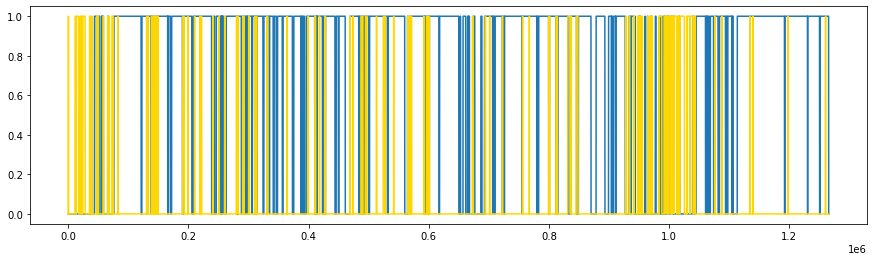

In [156]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 4))
plt.plot(new_df.index, new_df['ADULT'])
plt.plot(new_df.index, new_df['CHILD'], color='gold')
plt.show()

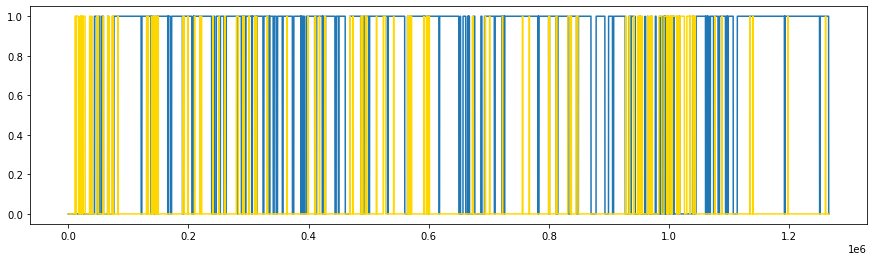

In [157]:
plt.figure(figsize=(15, 4))
plt.plot(new_df.index, new_df['SMOOTH_A'])
plt.plot(new_df.index, new_df['SMOOTH_C'], color='gold')
plt.show()

## TeacherPrint Data

In [40]:
def convert(n): 
    return time.strftime("%M min %S sec", time.gmtime(n))

### Summary

In [41]:
# Calculate the total time (sec).
tp_time = round(len(result.index)*.001,1)
print("TOTAL LESSON TIME: " + convert(tp_time)) 

TOTAL LESSON TIME: 21 min 06 sec


### Talk Time
#### Raw

In [42]:
# Calculate total talktime (sec).
tp_tt = round(((result['ADULT'].sum() + result['CHILD'].sum())*.001), 1)
print("TOTAL TALK TIME: " + convert(tp_tt)) 

# Calculate teacher talktime (sec and %).
tp_att = round(result['ADULT'].sum()*.001, 1)
tp_att_pc = int(round((tp_att/tp_tt)*100, 0))
print(tp_att, tp_att_pc)

# Calculate student talktime (sec and %).
tp_ctt = round(result['CHILD'].sum()*.001, 1)
tp_ctt_pc = int(round((tp_ctt/tp_tt)*100, 0))
print(tp_ctt, tp_ctt_pc)

print('During your lesson you spoke ' 
      + str(tp_att_pc) + '% of the time and the Students spoke ' 
      + str(tp_ctt_pc) + '% of the time.')

# Calculate the Talk Time metric ("For every second...".
tp_tt_metric = int(round(tp_att/tp_ctt, 0))

print('For every second of Student talk time, there were about ' 
      + str(tp_tt_metric) + ' seconds of Teacher talk time.')

TOTAL TALK TIME: 17 min 45 sec
937.2 88
128.1 12
During your lesson you spoke 88% of the time and the Students spoke 12% of the time.
For every second of Student talk time, there were about 7 seconds of Teacher talk time.


#### Smoothed
Pauses of one second or less between consecutive statements are smoothed out.

In [43]:
# Calculate total smoothed talktime (sec).
tp_tt_s = round(((result['SMOOTH_A'].sum() + result['SMOOTH_C'].sum())*.001), 1)
print("TOTAL TALK TIME: " + convert(tp_tt_s)) 

# Calculate teacher talktime (sec and %).
tp_att_s = round(result['SMOOTH_A'].sum()*.001, 1)
tp_att_pc_s = int(round((tp_att_s/tp_tt_s)*100, 0))
print(tp_att_s, tp_att_pc_s)

# Calculate student talktime (sec and %).
tp_ctt_s = round(result['SMOOTH_C'].sum()*.001, 1)
tp_ctt_pc_s = int(round((tp_ctt_s/tp_tt_s)*100, 0))
print(tp_ctt_s, tp_ctt_pc_s)

print('During your lesson you spoke ' 
      + str(tp_att_pc_s) + '% of the time and the Students spoke ' 
      + str(tp_ctt_pc_s) + '% of the time.')

# Calculate the Talk Time metric ("For every second...".
tp_tt_metric_s = int(round(tp_att_s/tp_ctt_s, 0))

print('For every second of Student talk time, there were about ' 
      + str(tp_tt_metric_s) + ' seconds of Teacher talk time.')

TOTAL TALK TIME: 18 min 05 sec
948.8 87
137.0 13
During your lesson you spoke 87% of the time and the Students spoke 13% of the time.
For every second of Student talk time, there were about 7 seconds of Teacher talk time.


### Statements
#### Raw

In [28]:
#Calculate number of statements.
tp_utt_a = result['UTT_A'].value_counts()[1]
tp_utt_c = result['UTT_C'].value_counts()[1]
tp_utt = tp_utt_a + tp_utt_c
print("TOTAL STATEMENTS: " + str(tp_utt)) 
print(tp_utt_a, tp_utt_c)

# Calculate average statement length.
tp_uttlen_a = round((tp_att/tp_utt_a), 1)
tp_uttlen_c = round((tp_ctt/tp_utt_c), 1)

print('Your average statement was ' 
      + str(tp_uttlen_a) + ' seconds long, while the average Student statement was ' 
      + str(tp_uttlen_c) + ' seconds long.')

# Calculate the Statement metric ("For every second...".
tp_utt_metric = int(round(tp_uttlen_a/tp_uttlen_c, 0))

print('For every second of Student statements, there were about ' 
      + str(tp_utt_metric) + ' seconds of Teacher statements.')

TOTAL STATEMENTS: 234
120 114
Your average statement was 7.8 seconds long, while the average Student statement was 1.1 seconds long.
For every second of Student statements, there were about 7 seconds of Teacher statements.


#### Smoothed
Pauses of one second or less between consecutive statements are smoothed out.

In [ ]:
#Calculate number of smoothed statements.
tp_utt_a_s = result['SMOOTH_UTT_A'].value_counts()[1]
tp_utt_c_s = result['SMOOTH_UTT_C'].value_counts()[1]
tp_utt_s = tp_utt_a_s + tp_utt_c_s
print("TOTAL STATEMENTS: " + str(tp_utt_s)) 
print(tp_utt_a_s, tp_utt_c_s)

# Calculate average smoothed statement length.
tp_uttlen_a_s = round((tp_att_s/tp_utt_a_s), 1)
tp_uttlen_c_s = round((tp_ctt_s/tp_utt_c_s), 1)

print('Your average statement was ' 
      + str(tp_uttlen_a_s) + ' seconds long, while the average Student statement was ' 
      + str(tp_uttlen_c_s) + ' seconds long.')


# Calculate the Statement metric ("For every second...".
tp_utt_metric_s = int(round(tp_uttlen_a_s/tp_uttlen_c_s, 0))

print('For every second of Student statements, there were about ' 
      + str(tp_utt_metric_s) + ' seconds of Teacher statements.')

### Pauses

#### Raw

In [ ]:
# Calculate pause time (sec).
tp_pt = round(result['PAUSE'].sum()*.001, 1)
tp_pt_avg = (round((tp_pt/tp_utt), 1))
print("TOTAL PAUSE TIME: " + convert(tp_pt)) 
print("AVERAGE PAUSE TIME: " + convert(tp_pt_avg)) 

#Calculate number of pauses.
tp_pause_a = result['UTT_A'].value_counts()[-1]
tp_pause_a_avg = (round((tp_pause_a/tp_utt_a), 1))
print(tp_pause_a, tp_pause_a_avg)

tp_pause_c = result['UTT_C'].value_counts()[-1]
tp_pause_c_avg = (round((tp_pause_c/tp_utt_c), 1))
print(tp_pause_c, tp_pause_c_avg)

tp_pause_c = result['UTT_S'].value_counts()[-1]
tp_pause_pc = int(round((tp_pause_c/tp_utt)*100, 0))
print(tp_pause_c, tp_pause_pc)

print('On average, the Students waited ' +
      str(tp_pause_a_avg) + ' seconds after you stopped speaking to begin their turn. You typically waited ' +
      str(tp_pause_c_avg) + ' seconds to speak after the Students stopped.')

print('In this lesson, ' + str(tp_pause_pc) 
      + '% of Statements had pauses between them.')

TOTAL PAUSE TIME: 03 min 57 sec
AVERAGE PAUSE TIME: 00 min 01 sec
120 1.0
114 1.0
156 67
On average, the Students waited 1.0 seconds after you stopped speaking to begin their turn. You typically waited 1.0 seconds to speak after the Students stopped.
In this lesson, 67% of Statements had pauses between them.


#### Smoothed

In [39]:
# Calculate pause time (sec).
tp_pt_s = round(result['SMOOTH_PAUSE'].sum()*.001, 1)
tp_pt_avg_s = (round((tp_pt_s/tp_utt_s), 1))
print("TOTAL PAUSE TIME: " + convert(tp_pt_s)) 
print("AVERAGE PAUSE TIME: " + convert(tp_pt_avg_s)) 

#Calculate number of pauses.
tp_pause_a_s = result['SMOOTH_UTT_A'].value_counts()[-1]
tp_pause_a_avg_s = (round((tp_pause_a_s/tp_utt_a_s), 1))
print(tp_pause_a_s, tp_pause_a_avg_s)

tp_pause_c_s = result['SMOOTH_UTT_C'].value_counts()[-1]
tp_pause_c_avg_s = (round((tp_pause_c_s/tp_utt_c_s), 1))
print(tp_pause_c_s, tp_pause_c_avg_s)

tp_pause_s = result['SMOOTH_UTT_S'].value_counts()[-1]
tp_pause_pc_s = int(round((tp_pause_s/tp_utt_s)*100, 0))
print(tp_pause_s, tp_pause_pc)

print('On average, the Students waited ' +
      str(tp_pause_a_avg_s) + ' seconds after you stopped speaking to begin their turn. You typically waited ' +
      str(tp_pause_c_avg_s) + ' seconds to speak after the Students stopped.')

print('In this lesson, ' + str(tp_pause_pc_s) 
      + '% of Statements had pauses between them.')

TOTAL PAUSE TIME: 03 min 42 sec
AVERAGE PAUSE TIME: 00 min 01 sec
117 1.0
110 1.0
144 67
On average, the Students waited 1.0 seconds after you stopped speaking to begin their turn. You typically waited 1.0 seconds to speak after the Students stopped.
In this lesson, 63% of Statements had pauses between them.


### Overlaps
Still need to figure out directionality.

#### Raw

In [29]:
# Calculate overlap time (sec).
tp_ot = round(result['OVERLAP'].sum()*.001, 1)
print("TOTAL OVERLAP TIME: " + convert(tp_ot)) 

tp_overlap_pc = 100 - tp_pause_pc
tp_ot_avg = round(tp_ot/(tp_overlap_pc*tp_utt), 3)

print('The average overlap was about ' + str(tp_ot_avg) + ' seconds.')

print('In this lesson ' + str(tp_overlap_pc) 
      + '% of Statements had overlaps between them.')

TOTAL OVERLAP TIME: 00 min 36 sec
The average overlap was about 0.005 seconds.
In this lesson 33% of Statements had overlaps between them.


#### Smoothed

In [30]:
# Calculate smoothed overlap time (sec).
tp_ot_s = round(result['SMOOTH_OVERLAP'].sum()*.001, 1)
print("TOTAL OVERLAP TIME: " + convert(tp_ot_s)) 

tp_overlap_pc_s = 100 - tp_pause_pc_s
tp_ot_avg_s = round(tp_ot_s/(tp_overlap_pc_s*tp_utt_s), 3)

print('The average overlap was about ' + str(tp_ot_avg_s) + ' seconds.')

print('In this lesson ' + str(tp_overlap_pc_s) 
      + '% of Statements had overlaps between them.')

TOTAL OVERLAP TIME: 00 min 41 sec
The average overlap was about 0.005 seconds.
In this lesson 37% of Statements had overlaps between them.


### Speaker Wheel
#### Raw

In [31]:
# Calculate Speaker Wheel input values (percent).
sw_adult = int(round((tp_att-tp_ot)/tp_time*100))
sw_overlap = int(round(tp_ot/tp_time*100))
sw_child = int(round((tp_ctt-tp_ot)/tp_time*100))
sw_pause = int(round(tp_pt/tp_time*100))
sw_df = {"TEACHER": sw_adult, "OVERLAPS": sw_overlap, "STUDENT": sw_child, "PAUSES": sw_pause}
sw_df

{'TEACHER': 71, 'OVERLAPS': 3, 'STUDENT': 7, 'PAUSES': 19}

#### Smoothed
Pauses of one second or less between consecutive statements are smoothed out.

In [ ]:
# Calculate Speaker Wheel input values (percent) based on smoothed data.
sw_adult_s = int(round((tp_att_s-tp_ot_s)/tp_time*100))
sw_overlap_s = int(round(tp_ot_s/tp_time*100))
sw_child_s = int(round((tp_ctt_s-tp_ot_s)/tp_time*100))
sw_pause_s = int(round(tp_pt_s/tp_time*100))
sw_df_s = {"TEACHER": sw_adult, "OVERLAPS": sw_overlap, "STUDENT": sw_child, "PAUSES": sw_pause}
sw_df_s

# Generating masked Swahili lesson

In [ ]:
marvin_rttm = './data/rttm/mar_tz_swahili.rttm'
marvin_df = DfFromRttm(marvin_rttm)
dihard_rttm = './data/rttm/dih_tz_swahili.rttm'
dihard_df = SpeechifyDihardDF(DfFromRttm(dihard_rttm))

In [40]:
marvin_df.head(5)

,start,duration,class,end_time
0,0.041,0.289,CHI,0.330
1,11.148,1.549,CHI,12.697
2,13.492,1.075,SPEECH,14.567
3,13.492,3.827,CHI,17.319
4,14.992,2.101,SPEECH,17.093


In [41]:
dihard_df.head(5)

,start,duration,class,end_time
0,13.510,0.140,SPEECH,13.650
1,13.925,0.321,SPEECH,14.246
2,14.977,0.289,SPEECH,15.266
3,20.174,0.267,SPEECH,20.441
4,22.493,0.201,SPEECH,22.694


In [42]:
marvin = BuildOneHotEncodedDf(
            marvin_df,
            label_list = ['MAL', 'CHI', 'KCHI', 'FEM', 'SPEECH'],
            verbose=False)
dihard = BuildOneHotEncodedDf(
            dihard_df,
            label_list = ['SPEECH'],
            verbose=False)


        >> This DF has data that runs until 1266.388.
        >> That value was found at row 363 and is the sum of
           1192.84 and 73.548
        
 >>> From [0] for [1266.388] seconds until [1266.388] the col [base_col] will contain the value [nan]
                  base_col
millisecond_ints          
0                      NaN
1                      NaN
2                      NaN                   base_col
millisecond_ints          
1266385                NaN
1266386                NaN
1266387                NaN
>>> Processing label: MAL

Attempting update with DF from label MAL
>>> Processing label: CHI

Attempting update with DF from label CHI
>>> Processing label: KCHI

Attempting update with DF from label KCHI
>>> Processing label: FEM

Attempting update with DF from label FEM
>>> Processing label: SPEECH

Attempting update with DF from label SPEECH

        >> This DF has data that runs until 1266.511.
        >> That value was found at row 198 and is the sum of
         

In [43]:
marvin.head(5)

,MAL,CHI,KCHI,FEM,SPEECH
millisecond_ints,,,,,
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0


In [44]:
dihard.head(5)

,SPEECH
millisecond_ints,
0,0
1,0
2,0
3,0
4,0


In [133]:
def ApplyDihardMask(dihard_df,
                    marvin_df,
                    write_outer=None,
                    verbose=False):
    """ Given a millisecond-indexed {dihard_df} and
        a millisecond-indexed {marvin_df}, conducts an outer merge
        and then drop any records not present in the {dihard_df}
        dataframe. If {write_outer} is a valid file destination,
        generates a CSV of the full outer join to troubleshoot
        unexpected results.
    """

    outer = pd.merge(left       = marvin,
                    left_index  = True,
                    right       = dihard,
                    right_index = True,
                    how         = 'outer',
                    suffixes    = ('_mar', '_dih')
                   )
    outer.index.rename('millisecond_ints', inplace=True)
    
    if write_outer is not None:
        try:
            outer.to_csv(write_outer)
        except:
            print(f'-write_outer- parameter of {writer_outer}' \
                   'is not a valid destination. Nothing written.')
            
    result = outer.loc[outer['SPEECH_dih'].notna()]
    result.drop(columns=['SPEECH_mar'], inplace=True)
    result.rename(columns={'SPEECH_dih':'SPEECH'}, inplace=True)
    
    if verbose:
        print('Masking MARVIN with DIHARD resulted in the following changes:')
        print('\t\tMarvin\t\tDIHARD\t\tMasked')
        all_cols = [m for m in marvin.columns] \
                 + [d for d in dihard.columns] \
                 + [r for r in result.columns]
        for col in set(all_cols):
            mar_ct = int(marvin[col].sum()) if col in marvin.columns else np.nan
            dih_ct = int(dihard[col].sum()) if col in dihard.columns else np.nan
            res_ct = int(result[col].sum()) if col in result.columns else np.nan
            print(f'{col}\t\t{mar_ct}\t\t{dih_ct}\t\t{res_ct}')

    return result

In [136]:
masked = ApplyDihardMask(marvin, dihard, verbose=True)

Masking MARVIN with DIHARD resulted in the following changes:
		Marvin		DIHARD		Masked
KCHI		17134		nan		17134
CHI		119178		nan		119178
SPEECH		1106545		968442		968442
FEM		930319		nan		930319
MAL		24879		nan		24879


In [148]:
print(
      f'\tMAL: \t{int(masked.MAL.sum())} \t| {round(100 * masked.MAL.sum() / masked.shape[0], 1)}%\n',
      f'\tFEM: \t{int(masked.FEM.sum())} \t| {round(100 * masked.FEM.sum() / masked.shape[0], 1)}%\n',
      f'\tCHI: \t{int(masked.CHI.sum())} \t| {round(100 * masked.CHI.sum() / masked.shape[0], 1)}%\n',
      f'\tKCHI: \t{int(masked.KCHI.sum())} \t| {round(100 * masked.KCHI.sum() / masked.shape[0], 1)}%\n',
      f'\tSPEECH: {int(masked.SPEECH.sum())} \t| {round(100 * masked.SPEECH.sum() / masked.shape[0], 1)}%\n')

	MAL: 	24879 	| 2.0%
 	FEM: 	930319 	| 73.5%
 	CHI: 	119178 	| 9.4%
 	KCHI: 	17134 	| 1.4%
 	SPEECH: 968442 	| 76.5%



In [68]:
combined = ConsolidateLabels(combined) # ADULT from MAL, FEM; CHILD from CHI, KCHI
combined.head(5)

,MAL,CHI,KCHI,FEM,SPEECH_mar,SPEECH_dih,ADULT,CHILD
millisecond_ints,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0,False,False
1,0.0,0.0,0.0,0.0,0.0,0,False,False
2,0.0,0.0,0.0,0.0,0.0,0,False,False
3,0.0,0.0,0.0,0.0,0.0,0,False,False
4,0.0,0.0,0.0,0.0,0.0,0,False,False


In [70]:
smoothed = ApplySmoothing(combined)
smoothed = ConsolidateLabels(smoothed, {'SMOOTH_S': ['SMOOTH_A', 'SMOOTH_C']})
smoothed.head(5)

,MAL,CHI,KCHI,FEM,SPEECH_mar,SPEECH_dih,ADULT,CHILD,SMOOTH_A,SMOOTH_C,SMOOTH_S
millisecond_ints,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0,False,False,0,0,False
1,0.0,0.0,0.0,0.0,0.0,0,False,False,0,0,False
2,0.0,0.0,0.0,0.0,0.0,0,False,False,0,0,False
3,0.0,0.0,0.0,0.0,0.0,0,False,False,0,0,False
4,0.0,0.0,0.0,0.0,0.0,0,False,False,0,0,False


In [72]:
CountOverlapsOrPauses(combined, target_col='OVERLAP', pauses=False)
CountOverlapsOrPauses(combined, target_col='PAUSE', pauses=True)
FlagUtteranceBoundaries(combined, {'ADULT'     : 'UTT_A',
                                 'CHILD'     : 'UTT_C',
                                 'SPEECH_dih': 'UTT_S'})
combined.head(5)

,MAL,CHI,KCHI,FEM,SPEECH_mar,SPEECH_dih,ADULT,CHILD,SMOOTH_A,SMOOTH_C,SMOOTH_S,OVERLAP,PAUSE,UTT_A,UTT_C,UTT_S
millisecond_ints,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0,False,False,0,0,False,False,True,NaN,NaN,NaN
1,0.0,0.0,0.0,0.0,0.0,0,False,False,0,0,False,False,True,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0,False,False,0,0,False,False,True,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0,False,False,0,0,False,False,True,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0,False,False,0,0,False,False,True,0.0,0.0,0.0


In [73]:
CountOverlapsOrPauses(smoothed,
                      cols_to_check=['SMOOTH_A', 'SMOOTH_C'],
                      target_col='SMOOTH_OVERLAP',
                      pauses=False)
CountOverlapsOrPauses(smoothed,
                      cols_to_check=['SMOOTH_A', 'SMOOTH_C'],
                      target_col='SMOOTH_PAUSE',
                      pauses=True)
FlagUtteranceBoundaries(smoothed, {'SMOOTH_A'  : 'SMOOTH_UTT_A',
                                 'SMOOTH_C'  : 'SMOOTH_UTT_C',
                                 'SMOOTH_S'  : 'SMOOTH_UTT_S'})
smoothed.head(5)

,MAL,CHI,KCHI,FEM,SPEECH_mar,SPEECH_dih,ADULT,CHILD,SMOOTH_A,SMOOTH_C,...,OVERLAP,PAUSE,UTT_A,UTT_C,UTT_S,SMOOTH_OVERLAP,SMOOTH_PAUSE,SMOOTH_UTT_A,SMOOTH_UTT_C,SMOOTH_UTT_S
millisecond_ints,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0,False,False,0,0,...,False,True,NaN,NaN,NaN,False,True,NaN,NaN,NaN
1,0.0,0.0,0.0,0.0,0.0,0,False,False,0,0,...,False,True,0.0,0.0,0.0,False,True,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0,False,False,0,0,...,False,True,0.0,0.0,0.0,False,True,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0,False,False,0,0,...,False,True,0.0,0.0,0.0,False,True,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0,False,False,0,0,...,False,True,0.0,0.0,0.0,False,True,0.0,0.0,0.0


In [74]:
masked = smoothed[smoothed['SPEECH_dih']==True]

In [75]:
masked.describe()

,MAL,CHI,KCHI,FEM,SPEECH_mar,SPEECH_dih,SMOOTH_A,SMOOTH_C,UTT_A,UTT_C,UTT_S,SMOOTH_UTT_A,SMOOTH_UTT_C,SMOOTH_UTT_S
count,968319.000000,968319.000000,968319.000000,968319.000000,968319.000000,968442.0,968442.000000,968442.000000,968442.000000,968442.000000,968442.000000,968442.000000,968442.000000,968442.000000
mean,0.023761,0.078877,0.013355,0.891185,0.982709,1.0,0.901459,0.091571,0.000012,0.000005,0.000205,0.000011,0.000003,0.000012
std,0.152303,0.269547,0.114790,0.311408,0.130353,0.0,0.298045,0.288419,0.010462,0.012732,0.014333,0.009369,0.012569,0.009852
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000
25%,0.000000,0.000000,0.000000,1.000000,1.000000,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,1.000000,1.000000,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,1.000000,1.000000,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [76]:
smoothed.describe()

,MAL,CHI,KCHI,FEM,SPEECH_mar,SPEECH_dih,SMOOTH_A,SMOOTH_C,UTT_A,UTT_C,UTT_S,SMOOTH_UTT_A,SMOOTH_UTT_C,SMOOTH_UTT_S
count,1.266388e+06,1.266388e+06,1.266388e+06,1.266388e+06,1.266388e+06,1.266511e+06,1.266511e+06,1.266511e+06,1.266510e+06,1.266510e+06,1.266510e+06,1.266510e+06,1.266510e+06,1.266510e+06
mean,1.964564e-02,9.410860e-02,1.352982e-02,7.346240e-01,8.737804e-01,7.646534e-01,7.491115e-01,1.081633e-01,0.000000e+00,0.000000e+00,7.895713e-07,0.000000e+00,0.000000e+00,0.000000e+00
std,1.387793e-01,2.919799e-01,1.155282e-01,4.415334e-01,3.320968e-01,4.242154e-01,4.335246e-01,3.105867e-01,1.376580e-02,1.341724e-02,1.770480e-02,1.359264e-02,1.317975e-02,1.507968e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [77]:
combined.describe()

,MAL,CHI,KCHI,FEM,SPEECH_mar,SPEECH_dih,SMOOTH_A,SMOOTH_C,UTT_A,UTT_C,UTT_S,SMOOTH_UTT_A,SMOOTH_UTT_C,SMOOTH_UTT_S
count,1.266388e+06,1.266388e+06,1.266388e+06,1.266388e+06,1.266388e+06,1.266511e+06,1.266511e+06,1.266511e+06,1.266510e+06,1.266510e+06,1.266510e+06,1.266510e+06,1.266510e+06,1.266510e+06
mean,1.964564e-02,9.410860e-02,1.352982e-02,7.346240e-01,8.737804e-01,7.646534e-01,7.491115e-01,1.081633e-01,0.000000e+00,0.000000e+00,7.895713e-07,0.000000e+00,0.000000e+00,0.000000e+00
std,1.387793e-01,2.919799e-01,1.155282e-01,4.415334e-01,3.320968e-01,4.242154e-01,4.335246e-01,3.105867e-01,1.376580e-02,1.341724e-02,1.770480e-02,1.359264e-02,1.317975e-02,1.507968e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


## Sanity-checking the Marvin and DIHARD DFs

In [76]:
# https://stackoverflow.com/questions/39502345/compare-columns-of-pandas-dataframe-for-equality-to-produce-true-false-even-nan?rq=1
combined['matched'] = np.where(combined['SPEECH_mar']==combined['SPEECH_dih'], True, False)

In [79]:
combined['matched'].sum() / combined['matched'].shape[0]

0.8643241156215777

In [93]:
print('DIHARD and Marvin both agreed that [X] was speech...')
for col in ['MAL', 'KCHI', 'CHI', 'FEM']:
    count = combined[combined["matched"]==False][col].sum()
    total_obs = combined[combined[col]==1].shape[0]
    pct = count/total_obs
    print(f'\t{col} : {round(100 * pct, 1)}%')
print('of the time the label was assigned')

DIHARD and Marvin both agreed that [X] was speech...
	MAL : 5.4%
	KCHI : 24.5%
	CHI : 31.7%
	FEM : 7.2%
of the time the label was assigned


In [ ]:
print('With the DIHARD masking applied, overall talk time changed as follows:')
print('\tMarvin\t\tDIHARD')
for col in ['MAL', 'KCHI', 'CHI', 'FEM']:
    mar_count = combined[combined['SPEECH_mar']==True][col].sum()
    mar_speech = combined['SPEECH_mar'].sum()
    mar_pct = mar_count / mar_speech
    dih_count = combined[combined['SPEECH_dih']==True][col].sum()
    dih_speech = combined['SPEECH_dih'].sum()
    dih_pct = dih_count / dih_speech
    print(f'{col}\t{round(100 * mar_pct, 1)}%\t\t{round(100 * dih_pct, 1)}%')

In [137]:
# Sanity Checks
# new_df.loc[(new_df['OVERLAP']==False) & (new_df['SMOOTH_OVERLAP']==True)]
# new_df.loc[(new_df['OVERLAP']==True) & (new_df['SMOOTH_OVERLAP']==False)]